# **RAG: Chunking Techniques**

## Introduction

Retrieval-Augmented Generation (RAG) is a framework that enhances large language models (LLMs) by integrating external knowledge retrieval during response generation. Rather than relying solely on the model’s internal parameters, RAG retrieves relevant information from a knowledge base (e.g., documents, databases, or web sources) and uses it to inform more accurate, grounded, and up-to-date outputs.

A critical component of the RAG pipeline is **chunking**, the process of dividing large texts or documents into smaller, manageable, and semantically meaningful segments called **chunks**. Effective chunking improves retrieval quality by ensuring that relevant context can be efficiently indexed and surfaced during a query. Poor chunking, on the other hand, can lead to irrelevant or partial context being retrieved, reducing the model’s performance.

In this project we explore different techniques, its difference and then we check the performance of each method.

In order to do that, I use a text that is about the women's football in England and how it was banned in 1921. The text was gotten from https://www.thefa.com/womens-girls-football/heritage/kicking-down-barriers using Web Scraping.

## Before starting

Let's start by reading te file

In [24]:
lines = []
with open('english_women_football.txt', 'r') as file:
    for line in file:
        if line.strip():
            lines.append(line.strip())

file_lines = "\n".join(lines)
lines

['EARLY YEARS',
 'Although the game of football. has been played for centuries – for example, Shakespeare mentions it in two of his plays: The Comedy of Errors (1594) and King Lear (1608) – you might think that women have only been playing over the last generation or so. In fact, their participation dates back much further than you might imagine. It is claimed that Mary Queen of Scots herself owned the oldest football in existence. Sir Philip Sidney’s poem A Dialogue Between Two Shepherds, written in 1580, refers to women playing:',
 '‘A tyme there is for all, my mother often sayes,',
 'When she, with skirts tuckt very hy, with girles at football playes.’',
 'Football remained a popular pastime, but it took another 300 years for the game to be codified into a standard set of rules by the newly formed Football Association in 1863. These rules were partly intended to stop on-pitch violence and make it more acceptable for women to play.',
 'The first recorded women’s football match was on

### *Overlapping*

Related to chunking I should mention the concept of **overlapping**. Overlapping in chunking means that adjacent chunks share some portion of text (e.g., sentences or tokens). This helps preserve context across chunk boundaries and reduces the chance of cutting off important information.

In overlapping chunking, each new chunk reuses some tokens from the previous chunk. This shared portion (the overlap) ensures smoother context continuity, especially when important information spans across boundaries.

Example (with 50-token chunks and 10-token overlap):
* Chunk 1: Tokens 0–49
* Chunk 2: Tokens 40–89 (overlapping tokens 40–49)
* Chunk 3: Tokens 80–129 (overlapping tokens 80–89)

This way, key information that falls near the edge of a chunk isn't lost between chunks during retrieval.

## Chunking Methods

### **Fixed Size Chunking**

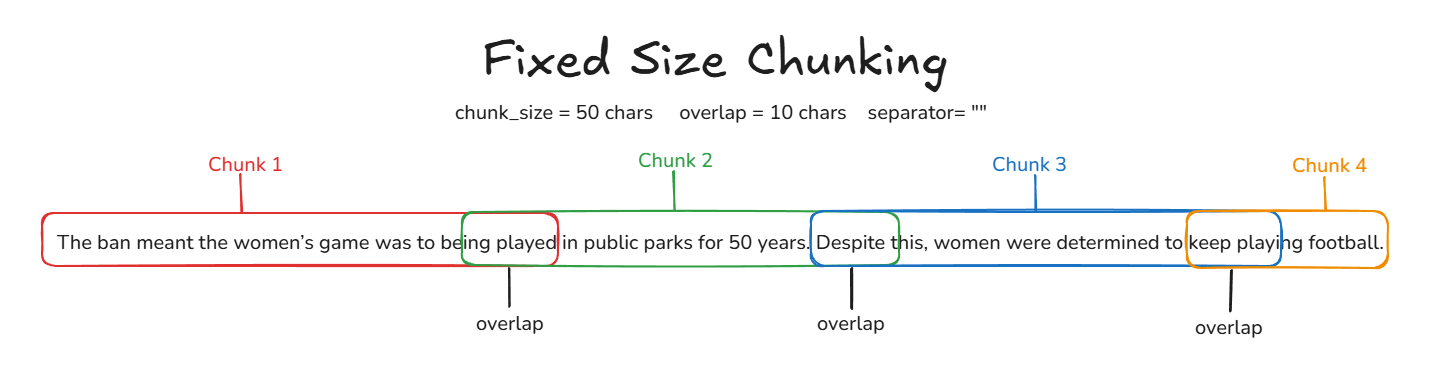

**Fixed-Size Chunking** breaks text into chunks of a predefined, fixed size, typically by a number of characters, tokens, or words.

Choose a **chunk size** (e.g. 500 tokens), optionally a fixed **overlap** (e.g. 50 tokens) and a chunk **separator**.

It splits the text into chunks of exactly that size, regardless of sentence, paragraph boundaries or structure of the content.

The separator is used to split the text into pieces first, and then those pieces are grouped into chunks of size ≤ chunk_size

Considerations:
* It does not try smaller separators if the chunk is too big.
* It does not preserve semantic or structural boundaries beyond that first split.

How it works:

1. The input text is split using the separator, e.g seperator ="\n". Then we have a list of lines.

2. Then it groups these lines into chunks of ≤ chunk_size characters, by concatenating multiple lines until the limit is hit.

*But if any single line is already longer than chunk_size, It will just include that line as a chunk and it shows a warning like:
"Created a chunk of size 518, which is longer than the specified 30".*

The chunk size is used to control how many combined short lines go into a chunk.
So, **Not to split individual lines that are too long**

#### Implementation

In order to impment this, I use CharacterTextSplitter from **LangChain**.

In [25]:
from langchain_text_splitters import CharacterTextSplitter
text_splitter = CharacterTextSplitter()
chunks = text_splitter.split_text(file_lines)
len(chunks)

1

In [26]:
chunks

['EARLY YEARS\nAlthough the game of football. has been played for centuries – for example, Shakespeare mentions it in two of his plays: The Comedy of Errors (1594) and King Lear (1608) – you might think that women have only been playing over the last generation or so. In fact, their participation dates back much further than you might imagine. It is claimed that Mary Queen of Scots herself owned the oldest football in existence. Sir Philip Sidney’s poem A Dialogue Between Two Shepherds, written in 1580, refers to women playing:\n‘A tyme there is for all, my mother often sayes,\nWhen she, with skirts tuckt very hy, with girles at football playes.’\nFootball remained a popular pastime, but it took another 300 years for the game to be codified into a standard set of rules by the newly formed Football Association in 1863. These rules were partly intended to stop on-pitch violence and make it more acceptable for women to play.\nThe first recorded women’s football match was on 7 May 1881, wh

By default the separator is "\n\n", so we have just one chunk with all the lines. As it was explained, the separator is used to split the text into pieces first, and as it is higher than the chunk size it keeps as it.

Let's set a new seperator without overlaping.

In [27]:
text_splitter = CharacterTextSplitter(chunk_size=50, chunk_overlap=0, separator=" ")
chunks = text_splitter.split_text(file_lines)
len(chunks)

369

In [28]:
chunks[0:5]

['EARLY YEARS\nAlthough the game of football. has',
 'been played for centuries – for example,',
 'Shakespeare mentions it in two of his plays: The',
 'Comedy of Errors (1594) and King Lear (1608) – you',
 'might think that women have only been playing over']

With this configuration we have 369 chunks of 50 characters. As we can see, this tecnique splits in the middle of sentences or words, and doesn't keep the semantic context.

In the first chunk we can see the title and the first line together.

Now let's set a overlapping

In [29]:
text_splitter = CharacterTextSplitter(chunk_size=50, chunk_overlap=5, separator=" ")
chunks = text_splitter.split_text(file_lines)
len(chunks)

394

In [32]:
chunks[0:10]

['EARLY YEARS\nAlthough the game of football. has',
 'has been played for centuries – for example,',
 'Shakespeare mentions it in two of his plays: The',
 'The Comedy of Errors (1594) and King Lear (1608) –',
 '– you might think that women have only been',
 'been playing over the last generation or so. In',
 'In fact, their participation dates back much',
 'much further than you might imagine. It is claimed',
 'that Mary Queen of Scots herself owned the oldest',
 'football in existence. Sir Philip Sidney’s poem A']

From above we can see that we have more chunks than before, and also how each chunk has words from the previous one.

To summarize this method:

Pros:
* Simple and fast to implement.
* Works well when structure doesn’t matter.
* Easy to control memory usage and token limits.

Cons:
* Can split in the middle of sentences or words.
* May lose semantic context if a thought spans across chunks. This doesn’t guarantee sentence or paragraph boundaries

As solution of these cons, we have the **Recursive Chunking** method.

### **Recursive Chunking**

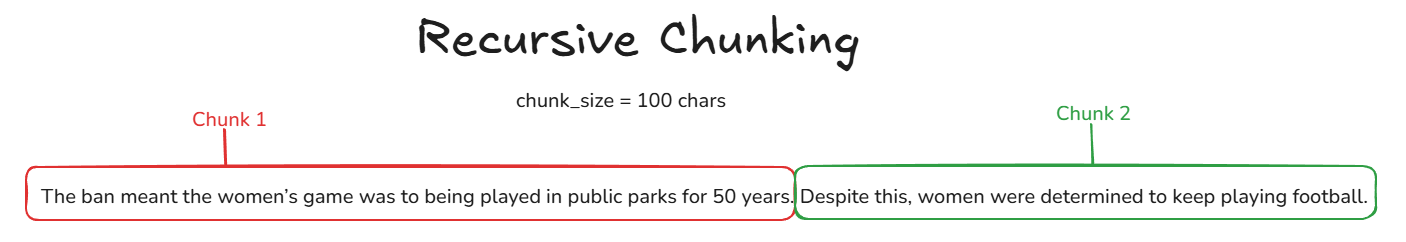

**Recursive Chunking** breaks text into chunks by recursively trying to preserve natural structure (e.g. paragraphs, sentences, words) while staying under a token limit.

How it works:
1. Define a max token size (e.g. 500 tokens).
2. Try splitting by paragraphs first. If a paragraph is too large, then it splits into sentences.
3. If a sentence is still too large, split it into phrases or words.
4. Optionally use overlap between chunks for context retention.

Pros:
* Maintains semantic coherence.
* Avoids splitting mid-sentence or mid-thought (as the previous technique)
* Better for LLMs and semantic search tasks.

Cons:
* More complex to implement.
* Slightly slower due to the recursive process.

#### Implementation

In [34]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=15)
chunks = text_splitter.split_text(file_lines)

In [36]:
chunks[0:5]

['EARLY YEARS',
 'Although the game of football. has been played',
 'been played for centuries – for example,',
 '– for example, Shakespeare mentions it in two of',
 'it in two of his plays: The Comedy of Errors']

We can see how the chunks mantain the semantic of the text, the title is in a new line, instead of all in the same line like in the Fixed Size where we had "EARLY YEARS\nAlthough the game of football. has been"

Here the separator is a list, where the default value is ["\n\n", "\n", " ", ""].

It tries to split first by paragraph, then by new line, then by space and finally by character, until the chunks are small enough.

### **Semantic Splitting**

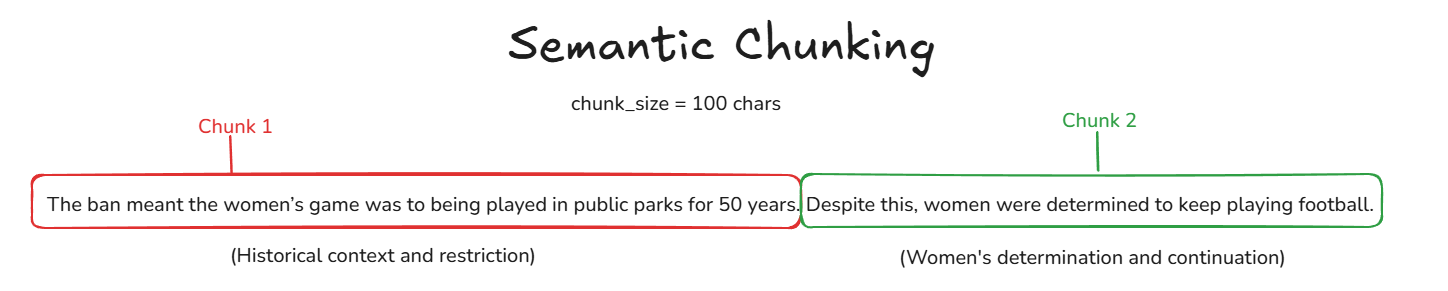

This means dividing text into chunks based on its meaning, not just character counts, tokens, or punctuation. The idea is to keep conceptually complete and coherent pieces of text together in each chunk. Things like full sentences, paragraphs, or topics — so that LLMs can better understand and work with them

How it Works:
1. Split into candidate units: Usually sentences or paragraphs.
2. Embed each unit: Convert text into vectors using an embedding model (like OpenAI, HuggingFace).
3. Group semantically similar units:
4. Use cosine similarity between adjacent vectors.
5. Merge sentences or paragraphs until the similarity drops or a token limit is hit.
6. Create semantically meaningful chunks.


Pros:
* Preserves meaning: Keeps related sentences and ideas together, reducing loss of context.
* Avoids arbitrary cuts: Doesn’t split mid-sentence or mid-thought, unlike fixed-size splitting.
* More human-like: Mimics how humans chunk text — by concepts and ideas.
* Reduces hallucinations: When input is semantically coherent, LLMs are less likely to invent false connections.
* Improves retrieval precision: Better matches for semantic search and vector similarity.

Cons:
* More complex to implement: Requires embeddings, similarity calculations, sometimes clustering algorithms.
* Slower processing: You need to compute sentence embeddings (often in batch), which takes time.
* Chunk sizes can be uneven: No strict control over token/character counts — might produce very large or very small chunks.
* Needs a semantic model: Requires an embedding model (like sentence-transformers or OpenAI's embedding API), which might not be free.

#### Implementation

In [61]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
text_splitter = SemanticChunker(OpenAIEmbeddings())
docs = text_splitter.split_text(file_lines)   

In [62]:
docs[0:5]

['EARLY YEARS\nAlthough the game of football. has been played for centuries – for example, Shakespeare mentions it in two of his plays: The Comedy of Errors (1594) and King Lear (1608) – you might think that women have only been playing over the last generation or so. In fact, their participation dates back much further than you might imagine. It is claimed that Mary Queen of Scots herself owned the oldest football in existence. Sir Philip Sidney’s poem A Dialogue Between Two Shepherds, written in 1580, refers to women playing:\n‘A tyme there is for all, my mother often sayes,\nWhen she, with skirts tuckt very hy, with girles at football playes.’\nFootball remained a popular pastime, but it took another 300 years for the game to be codified into a standard set of rules by the newly formed Football Association in 1863. These rules were partly intended to stop on-pitch violence and make it more acceptable for women to play.',
 'The first recorded women’s football match was on 7 May 1881,

In [63]:
sizes = [len(doc) for doc in docs]
sizes

[929, 357, 114, 3881, 576, 1150, 4468, 6214]

This has generated 8 chunks, all with different sizes.

### **LLM Based Chunking**

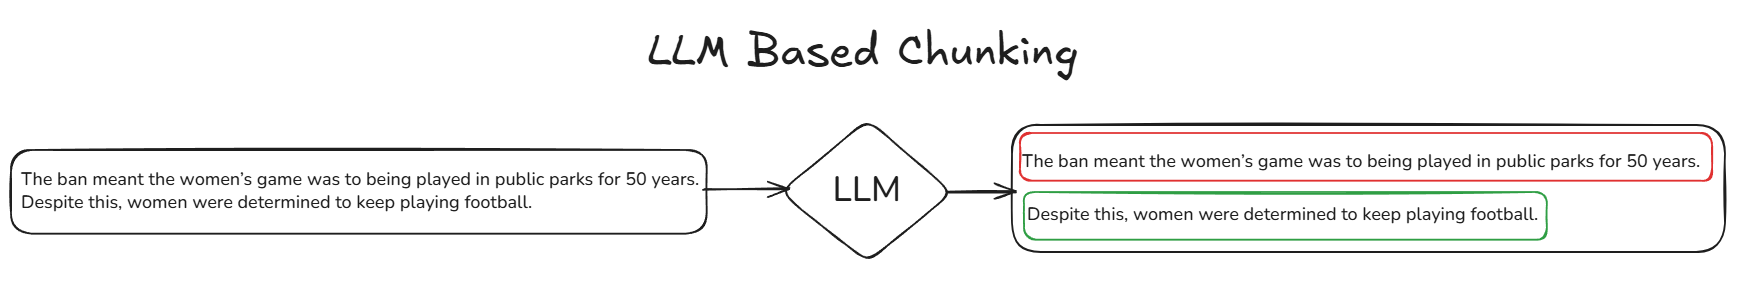

This method uses a LLM to generate chunks. The LLM processes the text and generates semantically isolated sentencees or propotions that can stand alone.

This is different from:
* Fixed-size splitting (blindly slicing by tokens)
* Recursive splitting (splitting by separators)
* Embedding-based splitting (using vector similarity)

Here, the LLM uses its own understanding to decide how to split.

Pros:
* Extremely flexible (you can tell the LLM exactly how to split, example to take care of the tiitle, paragraph..)
* Very semantically aware
* No need to hand-craft separator rules

Cons:
* Slower (LLM inference per document)
* Costlier (uses tokens to process the entire text, and could lead to context overflow)
* Needs good prompt engineering

What is the difference between this and Semantic Chunking?
* This uses a LLM to segment the text. On the other hand the Semantic uses Embeddings.
* The LLM reads the full text and intelligently splits it into coherent, meaningful chunks. On the other hand Semantic uses embedding similarity to decide where to split or merge based on semantic shifts.
* LLM is slower and more expensive, Semantic is faster and cheaper (uses embedding model only)

LLM is like asking a smart editor to break your document into logical sections and Semantic is like a machine looking for topic changes by comparing paragraph meanings

#### Implementation

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import json

prompt = ChatPromptTemplate.from_template("""
You are an expert document processor. 
Split the following text into coherent chunks of **no more than {chunk_size} characters** each. 
Try to preserve sentence boundaries, but keep the chunk under {chunk_size} characters.
Each chunk should be semantically meaningful and should not split sentences mid-way.

Return the result as a JSON array of strings, like this:
[
  "Chunk 1 text here...",
  "Chunk 2 text here...",
  ...
]
Only return the JSON. Do not include any other text.

Text:
{text}
""")

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
chain = prompt | llm
response = chain.invoke({
    "chunk_size": 50,
    "text": file_lines
})

chunks = json.loads(response.content)

In [ ]:
chunks[0:5]

['EARLY YEARS Although the game of football has been played for centuries – for example, Shakespeare mentions it in two of his plays: The Comedy of Errors (1594) and King Lear (1608) – you might think that women have only been playing over the last generation or so.',
 'In fact, their participation dates back much further than you might imagine. It is claimed that Mary Queen of Scots herself owned the oldest football in existence. Sir Philip Sidney’s poem A Dialogue Between Two Shepherds, written in 1580, refers to women playing: ‘A tyme there is for all, my mother often sayes, When she, with skirts tuckt very hy, with girles at football playes.’',
 'Football remained a popular pastime, but it took another 300 years for the game to be codified into a standard set of rules by the newly formed Football Association in 1863. These rules were partly intended to stop on-pitch violence and make it more acceptable for women to play.',
 'The first recorded women’s football match was on 7 May 18

In [95]:
class LLMChunker:
    def __init__(self, model="gpt-3.5-turbo", chunk_size=50):
        """
        Initializes the LLMChunker with the specified model and chunk size.
        """
        self.llm = ChatOpenAI(model=model, temperature=0)
        self.chunk_size = chunk_size
        self.prompt = ChatPromptTemplate.from_template("""
        You are an expert document processor. 
        Split the following text into coherent chunks of **no more than {chunk_size} characters** each. 
        Try to preserve sentence boundaries, but keep the chunk under {chunk_size} characters.
        Each chunk should be semantically meaningful and should not split sentences mid-way.

        Return the result as a JSON array of strings, like this:
        [
          "Chunk 1 text here...",
          "Chunk 2 text here...",
          ...
        ]
        Only return the JSON. Do not include any other text.

        Text:
        {text}
        """)

    def split_text(self, text):
        """
        Splits the given text into chunks using the LLM.

        Args:
            text (str): The text to split.

        Returns:
            list: A list of chunks.
        """
        chain = self.prompt | self.llm
        response = chain.invoke({
            "chunk_size": self.chunk_size,
            "text": text
        })
        return json.loads(response.content)

## Chunking Evaluation

In this section, we evaluate the quality of the chunks generated by different chunking methods using predefined metrics. These metrics assess the factual accuracy, relevance to the query, and the contextual usefulness of the retrieved chunks. The evaluation is conducted by generating questions and comparing the performance of each method.

After getting the chunks, how do we know if them are good enough or useful? There are some metrics to validate that.

Some metrics that we can validate are:
* Faithfulness (not hallucinated): Ensures that the retrieved chunks provide accurate information to the model, reducing hallucinations.
* Relevancy (Relevant to the query): Measures how well the retrieved chunks align with the user's query.
* Context Relevancy (Contextually useful to the LLM): Evaluates whether the retrieved chunks provide useful context for generating high-quality answers.

These are metrics/tools used to evaluate the quality of answers in RAG pipelines, especially how well the chunks retrieved contribute to:

| Evaluator                 | Purpose                                      |
|---------------------------|----------------------------------------------|
| FaithfulnessEvaluator     | Measures truthfulness of the answer vs context |
| RelevancyEvaluator        | Measures how relevant the answer is to the query |
| ContextRelevancyEvaluator | Measures how relevant the context (chunks) is to the query |

Where:
* Context, refers to the chunks retrieved from documents to answer that query
* Query, is the user's question.
* Answer, is the response generated by the LLM using the context and the query

Effective chunking is essential for ensuring that the RAG pipeline retrieves meaningful and accurate information. Poor chunking can result in irrelevant or incomplete context, reducing the quality of the generated responses

### Faithfulness Evaluator

What this checks:
* **Is the answer factually supported by the retrieved context?**

Tells you if your chunks provided enough or accurate information to answer the query.

This helps **detect hallucinations** (situations where the model generates answers not grounded in the source chunks)

Useful when comparing different chunking strategies to see which reduces hallucinations.

### Relevancy Evaluator

What this checks:
* **Is the answer actually relevant to the query?**

Helps you see if the answer reflects a meaningful match between query intent and retrieved text.

High relevancy = chunks aligned well with the query.

### Context Relevancy Evaluator

What this checks:
* **Are the retrieved chunks (context) actually relevant to the query?**

This doesn’t look at the final answer, it evaluates just the retrieved context.

Helps evaluate your retrieval and chunking strategy directly.

Tells you: "Did I retrieve good chunks?"

If low, your chunking may be too coarse, fine, or not semantically aligned..

### Summary table

| Evaluator                   | Evaluates…                    | Helps improve…                | Common Failure Reason        |
| --------------------------- | ----------------------------- | ----------------------------- | ---------------------------- |
| `FaithfulnessEvaluator`     | Answer vs. context (truth)    | Chunk coverage + accuracy     | Chunk too small or off-topic |
| `RelevancyEvaluator`        | Answer vs. query (focus)      | Model’s answer quality        | Irrelevant response          |
| `ContextRelevancyEvaluator` | Context vs. query (retrieval) | Chunking + retrieval strategy | Wrong or noisy chunks        |


### Chunks Evaluation

#### 1. Chunks Preparations

Before evaluating the performance of different chunking methods, it is essential to prepare the chunks in a structured and consistent manner. This involves splitting the text into chunks using various chunking techniques and configurations, saving these chunks for later use, and ensuring they are ready for evaluation.

In this section, we will:

1. Define the chunking methods and their parameters (e.g., chunk size, overlap).
2. Generate chunks for each method and configuration.
3. Save the prepared chunks to files for efficient retrieval during the evaluation process.

This preparation step ensures that all chunking methods are applied uniformly, enabling a fair comparison of their effectiveness in the subsequent evaluation phase.

In [99]:
import pickle

def save_chunks(text, chunk_sizes, chunk_path, splitter_class, **splitter_kwargs):
    """
    Splits text into chunks using the provided splitter class and saves them to files.

    Args:
        text (string): The text to split.
        chunk_sizes (list): A list of chunk sizes to use for splitting (ignored for SemanticChunker).
        chunk_path (str): Path where the files will be saved.
        splitter_class (class): The text splitter class to use (e.g., CharacterTextSplitter, SemanticChunker).
        **splitter_kwargs: Additional keyword arguments for the splitter class.
    """
    for size in chunk_sizes:
        # Initialize the splitter
        if splitter_class.__name__ == "CharacterTextSplitter":
            splitter = splitter_class(
                chunk_size=size,
                chunk_overlap=size / 10,  # Example: 10% overlap
                **splitter_kwargs
            )
        elif splitter_class.__name__ == "SemanticChunker":
            splitter = splitter_class(OpenAIEmbeddings())
        elif splitter_class.__name__ == "LLMChunker":
            splitter = splitter_class(chunk_size=50)    
        elif splitter_class.__name__ == "RecursiveCharacterTextSplitter":
            splitter = splitter_class(
                chunk_size=size,
                chunk_overlap=size / 10,
                **splitter_kwargs
            )

        chunks = splitter.split_text(text)
        file_name = f"{splitter_class.__name__}_chunksize_{size}.pkl"
        file_path = chunk_path + file_name

        # Save the chunks to a file
        with open(file_path, "wb") as file:
            pickle.dump(chunks, file)

        print(f"Chunks of size {size} saved to {file_path}")

In [ ]:
chunk_sizes = [50, 100, 150]
chunk_path = "./chunks/"
save_chunks(file_lines, chunk_sizes, chunk_path, CharacterTextSplitter, separator='')

Chunks of size 50 saved to ./chunks/CharacterTextSplitter_chunksize_50.pkl
Chunks of size 100 saved to ./chunks/CharacterTextSplitter_chunksize_100.pkl
Chunks of size 150 saved to ./chunks/CharacterTextSplitter_chunksize_150.pkl


In [ ]:
chunk_sizes = [50, 100, 150]
chunk_path = "./chunks/"
save_chunks(file_lines, chunk_sizes, chunk_path, RecursiveCharacterTextSplitter)

Chunks of size 50 saved to ./chunks/RecursiveCharacterTextSplitter_chunksize_50.pkl
Chunks of size 100 saved to ./chunks/RecursiveCharacterTextSplitter_chunksize_100.pkl
Chunks of size 150 saved to ./chunks/RecursiveCharacterTextSplitter_chunksize_150.pkl


In [ ]:
chunk_sizes = [1]
chunk_path = "./chunks/"
save_chunks(file_lines, chunk_sizes, chunk_path, SemanticChunker)

Chunks of size 1 saved to ./chunks/SemanticChunker_chunksize_1.pkl


In [100]:
chunk_sizes = [50]
chunk_path = "./chunks/"
save_chunks(file_lines.replace("\"", "'"), chunk_sizes, chunk_path, LLMChunker)

Chunks of size 50 saved to ./chunks/LLMChunker_chunksize_50.pkl


Let's see now some samples of the chunks per method

In [238]:
import pickle
import pandas as pd

methods = [
    "CharacterTextSplitter_chunksize_50.pkl",
    "RecursiveCharacterTextSplitter_chunksize_100.pkl",
    "SemanticChunker_chunksize_1.pkl",
    "LLMChunker_chunksize_50.pkl"
]
chunk_path = "./chunks/"
sample_chunks = {}

for method in methods:
    with open(chunk_path + method, "rb") as f:
        chunks = pickle.load(f)
        sample_chunks[method.replace(".pkl", "")] = chunks[:3]

df_samples = pd.DataFrame(sample_chunks)
df_samples.index = [f"Chunk {i+1}" for i in range(3)]
df_samples

,CharacterTextSplitter_chunksize_50,RecursiveCharacterTextSplitter_chunksize_100,SemanticChunker_chunksize_1,LLMChunker_chunksize_50
Chunk 1,EARLY YEARS\nAlthough the game of football. ha...,EARLY YEARS,EARLY YEARS\nAlthough the game of football. ha...,EARLY YEARS Although the game of football has ...
Chunk 2,"s been played for centuries – for example, Sha...",Although the game of football. has been played...,"The two teams played several matches, but two ...","In fact, their participation dates back much f..."
Chunk 3,akespeare mentions it in two of his plays: The...,it in two of his plays: The Comedy of Errors (...,In Glasgow the players had to escape in a hors...,"Football remained a popular pastime, but it to..."


Now that we have the methods, I wil ask to a model to create a set of questions from the original text, that will be used to evaluated what is the best split method.

In [48]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate        
translation_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
translation_prompt = PromptTemplate.from_template(
            """Based on the bellow context, Given the context information and not prior knowledge.
              generate only 40 questions.
                Generate the questions in English.
                Context: {context}"""
        )
translated_question = translation_llm.invoke(translation_prompt.format(context="\n".join(lines)))


Generated questions:

In [51]:
translated_question.content.split("\n")

["1. When was the first recorded women's football match?",
 '2. Who owned the oldest football in existence according to claims?',
 '3. What was the name of the poem written by Sir Philip Sidney in 1580 that refers to women playing football?',
 '4. How many goals did Lily St Clair score in the first match representing Scotland?',
 "5. What was the name of the team that won the Munitionettes' Cup in 1917?",
 '6. How many games did Dick, Kerr & Co win out of the 800 they played?',
 '7. Who is believed to have scored around 900 goals during her 30-year career?',
 "8. How many women's football clubs were there in 1921?",
 '9. Who described football as "the most unsuitable game, too much for a women\'s physical frame"?',
 "10. When was the ban on women's football lifted by the FA?",
 '11. When was the English Ladies Football Association (ELFA) formalized?',
 '12. Who won the first ELFA Challenge Cup competition in June 1922?',
 "13. When did the FA finally vote to rescind the ban on women's 

In [ ]:
import pandas as pd
# Create a DataFrame of the questions in order to save them to a CSV file
df = pd.DataFrame(translated_question.content.split("\n"), columns=['Questions'])
df.to_csv('questions.csv', index=False)

Now that we have the 40 questions, I evaluete the splits methods.

In [ ]:
from llama_index.core.evaluation import (
    FaithfulnessEvaluator,
    RelevancyEvaluator,
    ContextRelevancyEvaluator
)
from llama_index.core import (
    VectorStoreIndex,
    Document,
)
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.embeddings.openai import OpenAIEmbedding
import time

model = OpenAI(model="gpt-3.5-turbo", temperature=0)
faithfulness_evaluator = FaithfulnessEvaluator(llm=model)
relevancy_evaluator = RelevancyEvaluator(llm=model)
context_relevancy_evaluator = ContextRelevancyEvaluator(llm=model)

In [ ]:
def evaluate_response_time_and_accuracy(eval_documents, evaluation_questions):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0
    total_contextrelevancy = 0.0

    Settings.llm = OpenAI(model="gpt-3.5-turbo")
    Settings.embed_model = OpenAIEmbedding()
    # create vector index
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, embed_model=Settings.embed_model
    )
    num_questions = len(evaluation_questions)
    df = []

    for question in evaluation_questions:
        start_time = time.time()
        response_vector = vector_index.as_query_engine(llm=Settings.llm).query(question)
        elapsed_time = time.time() - start_time
        
        faithfulness_result = faithfulness_evaluator.evaluate_response(
            response=response_vector
        ).passing
        relevancy_result = relevancy_evaluator.evaluate_response(
            query=question, response=response_vector
        ).passing
        context_relevancy_result = context_relevancy_evaluator.evaluate_response(question, response_vector)

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result
        total_context_relevancy += context_relevancy_result.score

        data = {'question': question, 
                'response': response_vector.response,
                'context': [{'text': c.text, 'metadata': c.metadata} for c in response_vector.source_nodes],
                'faithfulness': faithfulness_result, 
                'relevancy': relevancy_result,
                'context_relevancy_score': context_relevancy_result.score,
                'context_relevancy_feedback': context_relevancy_result.feedback,
                'response_time': elapsed_time}

        df.append(data.copy())

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions
    average_contextrelevancy = total_contextrelevancy / num_questions
    return average_response_time, average_faithfulness, average_relevancy, average_contextrelevancy, df


In [ ]:
import os
import pandas as pd
import pickle

df = pd.read_csv('questions.csv')
evaluation_questions = df['Questions'].tolist()
results = {}

directory = './chunks'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    print(f"Processing file: {file_path}")
    with open(file_path, "rb") as file:
        chunk_docs = pickle.load(file)
    # Documents to llama-index docs
    llama_documents = [Document(text=doc) for doc in chunk_docs]
    avg_response_time, avg_faithfulness, avg_relevancy, average_contextrelevancy, df = evaluate_response_time_and_accuracy(llama_documents, evaluation_questions)
    results[filename] = { "Average response time": avg_response_time, "Average faithfulness": avg_faithfulness, "Average relevancy": avg_relevancy , "Average context relevancy": average_contextrelevancy}
    file_path = os.path.join('chunks_evaluations', filename.replace('.pkl', '_evaluation_answers.json'))
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(df, file, ensure_ascii=False, indent=4)


file_path = os.path.join('chunks_metrics.json')
with open(file_path, 'w') as file:
    json.dump(results, file)

Processing file: ./chunks\CharacterTextSplitter_chunksize_100.pkl
Processing file: ./chunks\CharacterTextSplitter_chunksize_150.pkl
Processing file: ./chunks\CharacterTextSplitter_chunksize_50.pkl
Processing file: ./chunks\RecursiveCharacterTextSplitter_chunksize_100.pkl
Processing file: ./chunks\RecursiveCharacterTextSplitter_chunksize_150.pkl
Processing file: ./chunks\RecursiveCharacterTextSplitter_chunksize_50.pkl
Processing file: ./chunks\SemanticChunker_chunksize_1.pkl


In [ ]:
with open('./chunks_metrics.json', 'r') as file:
    metrics = json.load(file)
df = pd.DataFrame(metrics).T

Here we can see the metrics for each method:

In [16]:
df

,Average response time,Average faithfulness,Average relevancy,Average context relevancy
CharacterTextSplitter_chunksize_100.pkl,1.373114,0.625,0.450,0.675000
CharacterTextSplitter_chunksize_150.pkl,1.373890,0.625,0.450,0.678125
CharacterTextSplitter_chunksize_50.pkl,1.682769,0.575,0.325,0.590625
RecursiveCharacterTextSplitter_chunksize_100.pkl,1.262391,0.675,0.400,0.718750
RecursiveCharacterTextSplitter_chunksize_150.pkl,1.038087,0.700,0.375,0.678125
RecursiveCharacterTextSplitter_chunksize_50.pkl,0.993778,0.625,0.325,0.584375
SemanticChunker_chunksize_1.pkl,1.164329,0.750,0.400,0.712500


But in order to them better, let's move the data to tha plot, to take better insights.

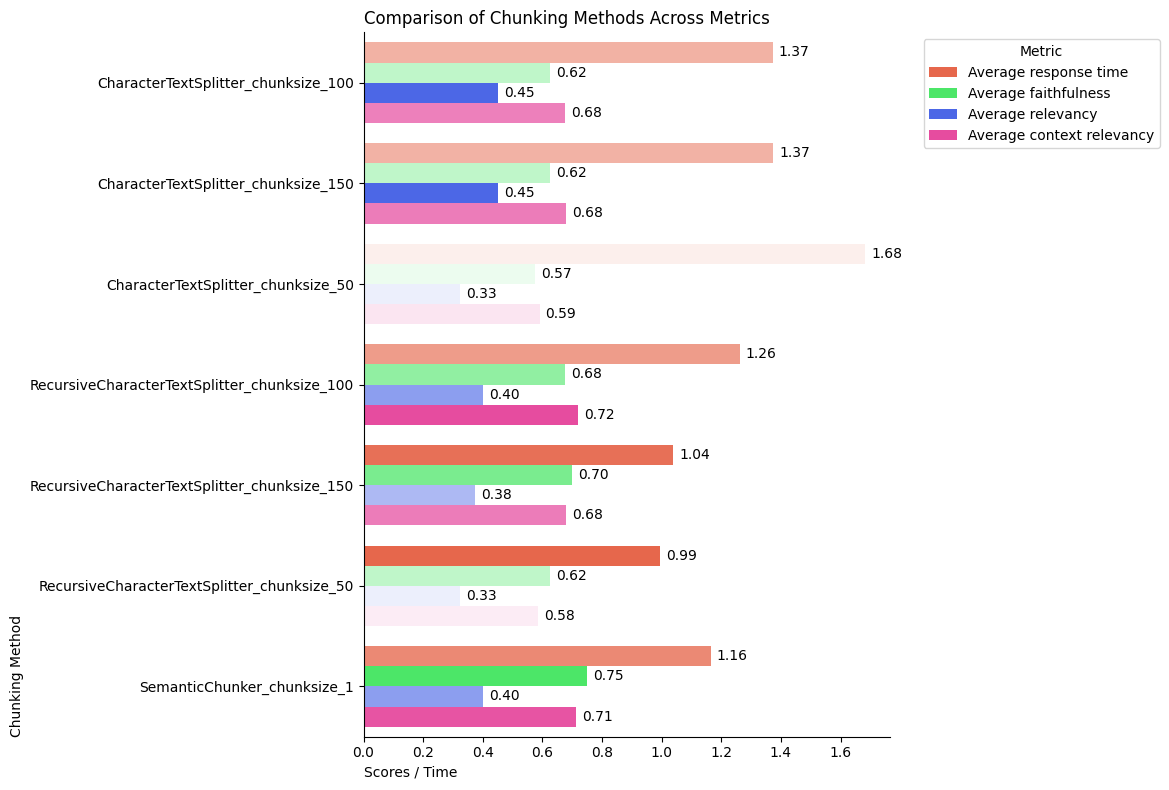

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "Chunking Method"})
metrics_df['Chunking Method'] = metrics_df['Chunking Method'].str.replace('.pkl', '', regex=False)
metrics_to_plot = ['Average response time', 'Average faithfulness', 'Average relevancy', 'Average context relevancy']

melted_df = metrics_df.melt(id_vars=["Chunking Method"], 
                            value_vars=metrics_to_plot, 
                            var_name="Metric", 
                            value_name="Score")

# Normalize the scores for opacity adjustment
def normalize_scores(row):
    if row['Metric'] == 'Average response time':
        # Invert normalization for response time (lower is better)
        return 1 - ((row['Score'] - melted_df[melted_df['Metric'] == 'Average response time']['Score'].min()) /
                    (melted_df[melted_df['Metric'] == 'Average response time']['Score'].max() -
                     melted_df[melted_df['Metric'] == 'Average response time']['Score'].min()))
    else:
        # Normal normalization for other metrics
        return (row['Score'] - melted_df[melted_df['Metric'] == row['Metric']]['Score'].min()) / \
               (melted_df[melted_df['Metric'] == row['Metric']]['Score'].max() -
                melted_df[melted_df['Metric'] == row['Metric']]['Score'].min())

melted_df['Normalized Score'] = melted_df.apply(normalize_scores, axis=1)
melted_df['Adjusted Opacity'] = melted_df['Normalized Score'] * 0.9 + 0.1

# Define a unique color for each metric
metric_colors = {
    'Average response time': '#FF5733',  # Red
    'Average faithfulness': '#33FF57',  # Green
    'Average relevancy': '#3357FF',     # Blue
    'Average context relevancy': '#FF33A1'  # Pink
}

plt.figure(figsize=(12, 8))
bars = sns.barplot(data=melted_df, 
                   x="Score", 
                   y="Chunking Method", 
                   hue="Metric", 
                   palette=metric_colors)

# Annotate each bar with its value
for bar, row in zip(bars.patches, melted_df.itertuples()):
    bar_x = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    plt.text(bar_x + 0.02,
             bar_y, 
             f"{row.Score:.2f}", 
             color='black', 
             va='center', 
             fontsize=10)

for bar, opacity in zip(bars.patches, melted_df['Adjusted Opacity']):
    bar.set_alpha(opacity)

plt.xlabel("Scores / Time", loc="left")
plt.ylabel("Chunking Method", loc="bottom")
plt.title("Comparison of Chunking Methods Across Metrics", loc='left')
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine()
plt.show()

#### Key Observations:

Average Response Time:

* The RecursiveCharacterTextSplitter_chunksize_50 has the lowest response time (0.993778 seconds), indicating it is the fastest method.
* The CharacterTextSplitter_chunksize_50 has the highest response time (1.682769 seconds), making it the slowest.
Average Faithfulness:
* The SemanticChunker_chunksize_1 achieves the highest faithfulness score (0.750), meaning it provides the most factually accurate responses.
* The CharacterTextSplitter_chunksize_50 has the lowest faithfulness score (0.575), indicating it struggles with factual accuracy.


Average Relevancy:
* All methods have relatively low relevancy scores, with the CharacterTextSplitter_chunksize_100 and CharacterTextSplitter_chunksize_150 tied at 0.450.
* The CharacterTextSplitter_chunksize_50 and RecursiveCharacterTextSplitter_chunksize_50 have the lowest relevancy scores (0.325), suggesting they are less aligned with the query intent.

Average Context Relevancy:
* The RecursiveCharacterTextSplitter_chunksize_100 achieves the highest context relevancy score (0.718750), meaning it retrieves the most relevant chunks for the query.
* The CharacterTextSplitter_chunksize_50 has the lowest context relevancy score (0.590625), indicating it retrieves less relevant chunks.

Chunking Method	Use Case Recommendation
* SemanticChunker_chunksize_1	Best for high accuracy and meaningful context retrieval.
* RecursiveCharacterTextSplitter_chunksize_100	Best for high context relevancy with good accuracy.
* RecursiveCharacterTextSplitter_chunksize_50	Best for speed-critical tasks with less focus on accuracy.
* CharacterTextSplitter_chunksize_50	Avoid due to poor performance across all metrics.

We can see the result in other way, for example by a heat map, where we can see how were the metrics per question and chunking method, for example the **context relevancy score**.

In [ ]:
import os
import json
import pandas as pd

eval_dir = './chunks_evaluations'
all_dfs = []

for filename in os.listdir(eval_dir):
    if filename.endswith('.json'):
        method = filename.replace('_evaluation_answers.json', '')
        with open(os.path.join(eval_dir, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        df['method'] = method
        all_dfs.append(df)

# Combine all methods into one DataFrame
full_df = pd.concat(all_dfs, ignore_index=True)

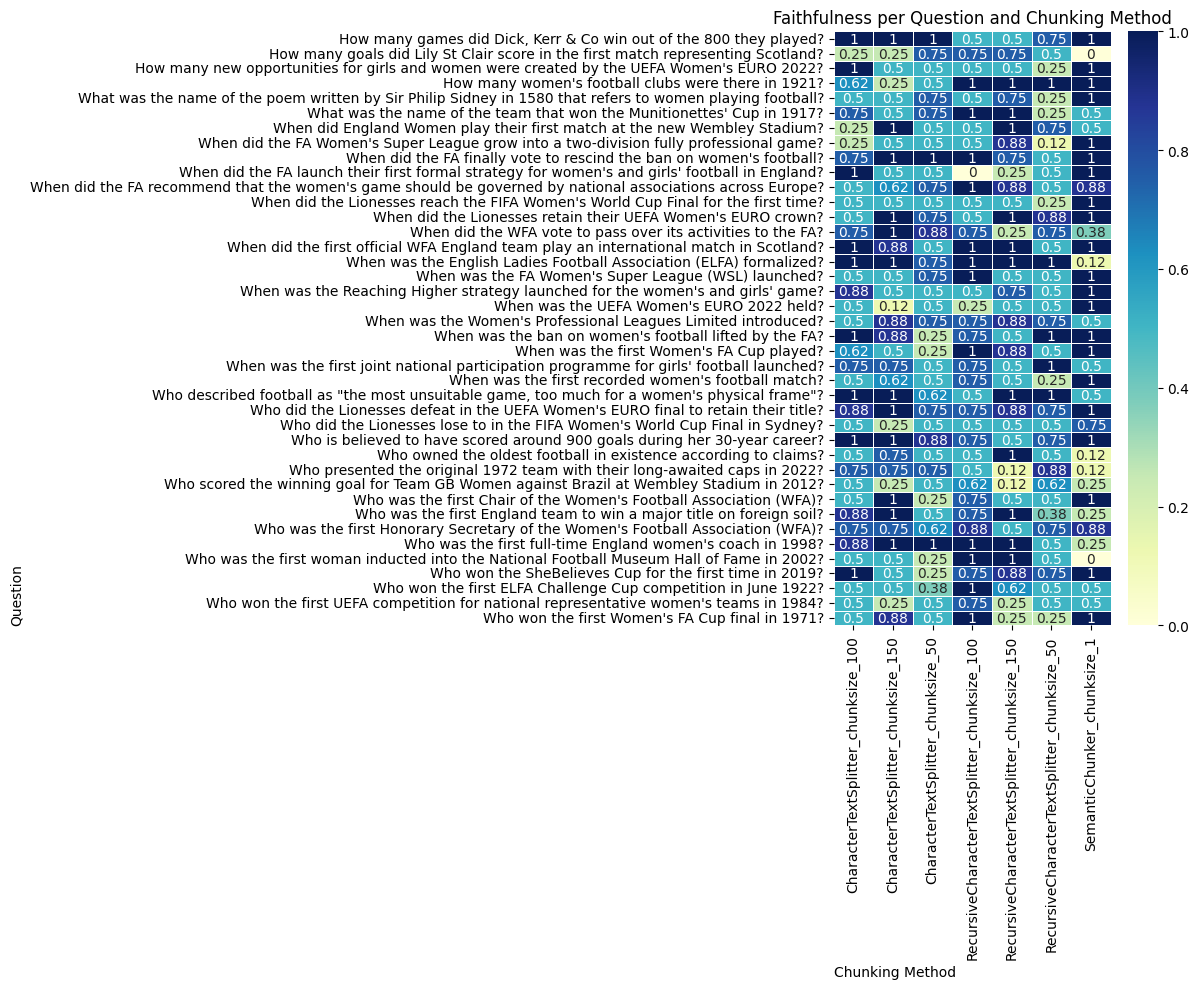

In [236]:
full_df['order'] = full_df['question'].str.split('.').str[0].str.strip()
full_df['question'] = full_df['question'].str.replace(r'^\d+\.\s*', '', regex=True)

# Recreate the heatmap DataFrame
heatmap_df = full_df.pivot(index='question', columns='method', values='context_relevancy_score')

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Faithfulness per Question and Chunking Method')
plt.ylabel('Question', loc='bottom')
plt.xlabel('Chunking Method', loc='left')
plt.tight_layout()
plt.show()

From above we can see that the **Semantic Chunker** consistently achieves high scores across most questions, indicating its ability to provide contextually relevant and accurate chunks. Also, the **Recursive Character Text Splitter** with a chunk size of 100 also performs well, particularly in terms of context relevancy. It is a good choice for balancing accuracy and retrieval quality. We can further check what happen if we increase the chunk size to 150 and 200.

## Conclusion

This notebook explores various chunking techniques and evaluates their effectiveness in the context of Retrieval-Augmented Generation (RAG) pipelines. The key findings and insights are summarized below:

1. **Chunking Techniques**:
* Different chunking methods, including Fixed-Size Chunking, Recursive Chunking, Semantic Splitting, and LLM-Based Chunking, were implemented and compared.
* Each method has its strengths and weaknesses, with trade-offs between speed, semantic coherence, and accuracy.

2. **Evaluation Metrics**:
* The evaluation focused on metrics such as Faithfulness, Relevancy, Context Relevancy, and Response Time.
* These metrics provided a comprehensive understanding of how well each chunking method supports accurate and relevant responses in RAG pipelines.

3. **Key Observations**:
* SemanticChunker_chunksize_1 achieved the highest faithfulness score, making it the most accurate method for retrieving meaningful context.
* RecursiveCharacterTextSplitter_chunksize_100 demonstrated the best context relevancy, indicating its ability to retrieve highly relevant chunks for queries.
* RecursiveCharacterTextSplitter_chunksize_50 was the fastest method, making it suitable for speed-critical tasks.
* CharacterTextSplitter_chunksize_50 performed poorly across most metrics and is not recommended for use.

4. Recommendations:
* Use Semantic Chunking for tasks requiring high accuracy and meaningful context retrieval.
* Opt for Recursive Chunking when balancing context relevancy and accuracy is critical.
* Avoid Fixed-Size Chunking for tasks requiring semantic coherence, as it often splits text mid-sentence or mid-thought.

5. Visualization:
* The heatmap and bar plots provided clear visual insights into the performance of each method, aiding in the selection of the most appropriate chunking strategy for specific use cases.